## Import Libs

In [1]:
import os
import random
import gc
import time
import copy
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler, CosineAnnealingLR
import timm

from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score

import warnings # 避免一些可以忽略的报错
warnings.filterwarnings('ignore')
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

/data1/hjs/anaconda3/envs/transformers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## CONFIG

In [2]:
is_debug = False
use_803098 = False
use_401059_val = True

use_1954_train = True # 2024_0 + 2024_1 + 2020_1 ----- 0 : 1 == 1 : 1
use_2442_train = False # 2024_0 + 2024_1 + 2020_1 ----- 0 : 1 == 1.5 : 1
use_2931_train = False # 2024_0 + 2024_1 + 2020_1 ----- 0 : 1 == 2 : 1

use_1977_train = False # 2024_0 + 2024_1 + 2020_1
use_10999_train = False # 2024_0 + 2024_1 + 2020_1 + 2019_1
use_401059_train = False # 2024_0 + 2024_1

class CONFIG:
    seed = 308
    epochs = 32 if not is_debug else 2
    
    train_batch_size = 64
    valid_batch_size = 512
    img_size = [160, 160]
    now_cv = 0
    n_classes = 1
    n_folds = 5
    
    n_accumulate = 1.0
    n_workers = os.cpu_count()
    
    formatted_time = None
    ckpt_save_path = None

    learning_rate = 1e-3 * train_batch_size * n_accumulate / 64
    # learning_rate = 1e-5 * train_batch_size / 32 # eva02
    if use_1954_train:
        total_sample = [1586, 1522, 1582, 1574, 1552] # 1954
    elif use_2442_train:
        total_sample = [1982, 1902, 1977, 1967, 1940] # 2442
    elif use_2931_train:
        total_sample = [2379, 2283, 2373, 2361, 2328] # 2931
    T_max = [total_sample[0] * epochs / train_batch_size // n_accumulate,
             total_sample[1] * epochs / train_batch_size // n_accumulate,
             total_sample[2] * epochs / train_batch_size // n_accumulate,
             total_sample[3] * epochs / train_batch_size // n_accumulate,
             total_sample[4] * epochs / train_batch_size // n_accumulate] # 401059
    min_lr = 1e-6
    weight_decay = 1e-6
    scheduler = "CosineAnnealingWithWarmupLR" # 'CosineAnnealingLR'
    DataParallel = True

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    """
    tf_efficientnet_b0_ns
    tf_efficientnetv2_s.in21k_ft_in1k
    tf_efficientnetv2_l.in21k_ft_in1k
    tf_efficientnet_b3.ns_jft_in1k
    tf_efficientnetv2_b0.in1k
    tf_efficientnetv2_b3.in21k_ft_in1k

    convnext_atto_ols.a2_in1k
    tiny_vit_21m_512.dist_in22k_ft_in1k
    deit_tiny_patch16_224.fb_in1k
    vit_tiny_patch16_224.augreg_in21k_ft_in1k

    eva02_base_patch14_224.mim_in22k

    swin_tiny_patch4_window7_224.ms_in22k
    
    convnextv2_tiny.fcmae_ft_in22k_in1k_384
    convnext_tiny.fb_in22k_ft_in1k_384

    efficientvit_b0.r224_in1k
    efficientvit_b3.r256_in1k
    resnet18.fb_swsl_ig1b_ft_in1k

    edgenext_base.in21k_ft_in1k
    edgenext_small.usi_in1k
    edgenext_x_small.in1k

    eca_nfnet_l0.ra2_in1k
    """
    model_name = "efficientvit_b3.r256_in1k"
    is_pretrained = False
    backbone_grad = True
    use_gempool = False
    ckpt_paths = "/data1/hjs/pythonProject/pythonProject/ISIC2024/ckpt"
    smooth_threshold = 0.05

    old_my_train_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/my_train_with_sgkfold.csv"
    my_train_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/my_train_with_sgkfold.csv"
    train_img_dir = "/data1/hjs/pythonProject/pythonProject/ISIC2024/image"
    new_train_img_dir = "/data1/hjs/pythonProject/pythonProject/ISIC2024/new_1_imgs"

    # train_1954_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_1954.csv"
    train_1954_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_1954_with_random_sample_sgkfold.csv"
    train_2442_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_2442.csv"
    train_2931_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_2931.csv"

    train_1977_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_1977.csv"
    train_793_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_793.csv"
    train_10999_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_10999.csv"

if CONFIG.DataParallel:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
    print("IN DataParallel!")
else:
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    print("NO IN DataParallel!")

IN DataParallel!


## Set Random Seed

In [3]:
def set_seed(seed=308):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(CONFIG.seed)

## Data Progress

In [4]:
# root_dir = "/kaggle/input/isic-2024-challenge/train-image/image"
# img_ids = os.listdir(root_dir)

# min_size = 9999
# max_size = 0
# n_0_64 = 0
# n_64_96 = 0
# n_96_160 = 0
# n_160_224 = 0
# n_224_269 = 0
# for img_id in tqdm(img_ids):
#     path = os.path.join(root_dir, img_id)
#     a = Image.open(path)
#     s = np.array(a).shape[0]
#     if s > max_size:
#         max_size = s
#     if s < min_size:
#         min_size = s
        
#     if s >= 0 and s < 64:
#         n_0_64 += 1
#     elif s >= 64 and s < 96:
#         n_64_96 += 1
#     elif s >= 96 and s < 160:
#         n_96_160 += 1
#     elif s >= 160 and s < 224:
#         n_160_224 += 1
#     elif s >= 224:
#         n_224_269 += 1
        
# print(f"max_size : {max_size}") # max_size : 269
# print(f"min_size : {min_size}") # min_size : 41

# print(f"n_0_64    : {n_0_64}")    # 86
# print(f"n_64_96   : {n_64_96}")   # 3461
# print(f"n_96_160  : {n_96_160}")  # 368914
# print(f"n_160_224 : {n_160_224}") # 28305
# print(f"n_224_269 : {n_224_269}") # 293

# """
# 以上代码运行时间 : 37:20
# """

In [5]:
if os.path.exists(CONFIG.my_train_csv):
    train = pd.read_csv(CONFIG.my_train_csv)
else:
    train = pd.read_csv(CONFIG.train_csv)

valid = pd.read_csv(CONFIG.old_my_train_csv)
train

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,kfold
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,4
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,0
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,0
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,2
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,4
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,1
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,2
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0


In [6]:
if not os.path.exists(CONFIG.my_train_csv):
    print("贴 KFold....")
    # # 设置StratifiedKFold参数
    # skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=308)

    # # 创建一个新的列来保存KFold标签
    # train['kfold'] = -1

    # # 遍历每个fold并分配标签
    # for fold, (train_idx, val_idx) in enumerate(skf.split(train, train['target'])):
    #     train.loc[val_idx, 'kfold'] = fold
train

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,kfold
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,4
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,0
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,0
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,2
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,4
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,1
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,2
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0


In [7]:
if use_803098:
    new_train = train
else:
    if use_1954_train:
        new_train = pd.read_csv(CONFIG.train_1954_csv)
    elif use_2442_train:
        new_train = pd.read_csv(CONFIG.train_2442_csv)
    elif use_2931_train:
        new_train = pd.read_csv(CONFIG.train_2931_csv)

    elif use_1977_train:
        new_train = pd.read_csv(CONFIG.train_1977_csv)
    elif use_10999_train:
        new_train = pd.read_csv(CONFIG.train_10999_csv)
    elif use_401059_train:
        new_train = pd.read_csv(CONFIG.my_train_csv)
    else:
        new_train = pd.read_csv(CONFIG.train_793_csv)
    # train_0 = train[train["target"] != 1] # 400666 rows × 56 columns
    # train_1 = train[train["target"] == 1] # 393 rows × 56 columns

    # train_0 = train_0.reset_index(drop=True)
    # train_1 = train_1.reset_index(drop=True)

    # # train_1[train_1["kfold"] == 4] # [78, 79, 79, 79, 78] sum --> 393

    # # 0 : 1 ---> 1020 : 1

    # # 每个 fold 取 80 个样本 总共 400
    # some_train_0 = []
    # for fold in range(CONFIG.n_folds):
    #     _tmp = train_0[train_0["kfold"] == fold].reset_index(drop=True).iloc[:200, :]
    #     some_train_0.append(_tmp)

    # some_train_0 = pd.concat(some_train_0).reset_index(drop=True)
    # some_train_0

    # new_train = pd.concat([some_train_0, train_1]).reset_index(drop=True)
    # new_train = pd.concat([new_train, train_1_2020]).reset_index(drop=True)
    # new_train = new_train.sample(frac=1).reset_index(drop=True)
new_train

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,kfold
0,ISIC_2884798,0,IP_2702014,80.0,male,posterior torso,3.42,TBP tile: close-up,3D: XP,16.258740,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.793029,2
1,ISIC_2340279,0,IP_3537591,45.0,male,posterior torso,4.54,TBP tile: close-up,3D: white,17.642915,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,91.430944,2
2,ISIC_5140952,1,IP_1264754,65.0,female,lower extremity,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,ISIC_9038318,1,IP_8502723,70.0,male,torso,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,ISIC_2943219,1,IP_4934005,60.0,male,head/neck,2.01,TBP tile: close-up,3D: white,22.806662,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,0.000003,4
1950,ISIC_3144222,1,IP_4615697,80.0,male,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1951,ISIC_5143941,1,IP_7215455,40.0,female,head/neck,6.05,TBP tile: close-up,3D: white,28.641970,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,87.415740,1
1952,ISIC_5847769,0,IP_4591603,50.0,male,lower extremity,4.23,TBP tile: close-up,3D: XP,19.839961,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.990118,1


## Dataset and DataLoader

In [8]:
# class HairAugmentation(A.ImageOnlyTransform):
#     def __init__(self, num_hairs=5, hair_color=(0, 0, 0), always_apply=False, p=0.5):
#         super(HairAugmentation, self).__init__(always_apply, p)
#         self.num_hairs = num_hairs
#         self.hair_color = hair_color

#     def apply(self, img, **params):
#         img = img.copy()
#         h, w, _ = img.shape
        
#         for _ in range(self.num_hairs):
#             # Randomly choose the position and size of the hair
#             x1, y1 = random.randint(0, w), random.randint(0, h)
#             x2, y2 = random.randint(0, w), random.randint(0, h)
#             thickness = random.randint(1, 1)  # Making the hair thinner
#             img = cv2.line(img, (x1, y1), (x2, y2), self.hair_color, thickness)
        
#         return img

#     def get_params_dependent_on_targets(self, params):
#         return {}

#     def get_transform_init_args_names(self):
#         return ("num_hairs", "hair_color")
    
# # HairAugmentation(num_hairs=10, hair_color=(0, 0, 0), p=1.0),

class HairAugmentation(A.ImageOnlyTransform):
    def __init__(self, num_hairs_range=(5, 15), hair_color_range=((0, 0, 0), (255, 255, 255)), always_apply=False, p=0.5):
        super(HairAugmentation, self).__init__(always_apply, p)
        self.num_hairs_range = num_hairs_range
        self.hair_color_range = hair_color_range

    def apply(self, img, **params):
        img = img.copy()
        h, w, _ = img.shape

        num_hairs = random.randint(self.num_hairs_range[0], self.num_hairs_range[1])
        hair_color = (
            random.randint(self.hair_color_range[0][0], self.hair_color_range[1][0]),
            random.randint(self.hair_color_range[0][1], self.hair_color_range[1][1]),
            random.randint(self.hair_color_range[0][2], self.hair_color_range[1][2])
        )

        for _ in range(num_hairs):
            # Randomly choose the position and size of the hair
            x1, y1 = random.randint(0, w), random.randint(0, h)
            x2, y2 = random.randint(0, w), random.randint(0, h)
            thickness = random.randint(1, 1)  # Making the hair thinner
            img = cv2.line(img, (x1, y1), (x2, y2), hair_color, thickness)

        return img

    def get_params_dependent_on_targets(self, params):
        return {}

    def get_transform_init_args_names(self):
        return ("num_hairs_range", "hair_color_range")
    
# HairAugmentation(num_hairs_range=(5, 15), hair_color_range=((0, 0, 0), (255, 255, 255)), p=1.0)

In [9]:
def transform(img):
    composition = A.Compose([
        A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
        ToTensorV2(),
    ])
    return composition(image=img)["image"]

# def transform_train(img):
#     composition = A.Compose([
#         A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#         HairAugmentation(num_hairs_range=(5, 15), hair_color_range=((0, 0, 0), (255, 255, 255)), p=0.5),
#         ToTensorV2(),
#     ])
#     return composition(image=img)["image"]


# def transform_val(img):
#     composition = A.Compose([
#         A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#         ToTensorV2(),
#     ])
#     return composition(image=img)["image"]

def transform_train(img):
    composition = A.Compose([
        HairAugmentation(num_hairs_range=(5, 15), hair_color_range=((0, 0, 0), (255, 255, 255)), p=0.5),
        A.Transpose(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightness(limit=0.2, p=0.75),
        A.RandomContrast(limit=0.2, p=0.75),
        A.OneOf([
            A.MotionBlur(blur_limit=5),
            A.MedianBlur(blur_limit=5),
            A.GaussianBlur(blur_limit=5),
            A.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),

        A.OneOf([
            A.OpticalDistortion(distort_limit=1.0),
            A.GridDistortion(num_steps=5, distort_limit=1.),
            A.ElasticTransform(alpha=3),
        ], p=0.7),

        A.CLAHE(clip_limit=4.0, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
        A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
        A.Cutout(max_h_size=int(CONFIG.img_size[0] * 0.375), max_w_size=int(CONFIG.img_size[1] * 0.375), num_holes=1, p=0.7),    
        A.Normalize(),
        ToTensorV2(),
    ])
    return composition(image=img)["image"]


def transform_val(img):
    composition = A.Compose([
        A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
        A.Normalize(),
        ToTensorV2(),
    ])
    return composition(image=img)["image"]

# transform_train = A.Compose([
#     A.Transpose(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightness(limit=0.2, p=0.75),
#     A.RandomContrast(limit=0.2, p=0.75),
#     A.OneOf([
#         A.MotionBlur(blur_limit=5),
#         A.MedianBlur(blur_limit=5),
#         A.GaussianBlur(blur_limit=5),
#         A.GaussNoise(var_limit=(5.0, 30.0)),
#     ], p=0.7),

#     A.OneOf([
#         A.OpticalDistortion(distort_limit=1.0),
#         A.GridDistortion(num_steps=5, distort_limit=1.),
#         A.ElasticTransform(alpha=3),
#     ], p=0.7),

#     A.CLAHE(clip_limit=4.0, p=0.7),
#     A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
#     A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#     A.Cutout(max_h_size=int(CONFIG.img_size[0] * 0.375), max_w_size=int(CONFIG.img_size[1] * 0.375), num_holes=1, p=0.7),    
#     A.Normalize(),
#     ToTensorV2(),
# ])

# transform_val = A.Compose([
#     A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#     A.Normalize(),
#     ToTensorV2(),
# ])

In [10]:
class MyDataset(Dataset):
    def __init__(self, df, transform=None, mode="train", threshold=CONFIG.smooth_threshold):
        super().__init__()
        self.df = df
        self.transform = transform
        self.mode = mode
        self.threshold = threshold

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx, :]
        img_id = row.isic_id + ".jpg"
        label = torch.tensor(row.target, dtype=torch.float32)
        
        if use_803098:
            if label.item() == 1:
                img_path = os.path.join(CONFIG.new_train_img_dir, img_id)
            else:
                img_path = os.path.join(CONFIG.train_img_dir, img_id)
        else:
            img_path = os.path.join(CONFIG.train_img_dir, img_id)
        img = Image.open(img_path)
        img = np.array(img)

        if self.transform != None:
            img = self.transform(img)
        
        if self.mode == "train":
            if label == 0:
                # label += (self.threshold / 2)
                label += self.threshold
            elif label == 1:
                # label -= (self.threshold / 2)
                label -= self.threshold
            else:
                raise("label is not 0 or 1")
        elif self.mode == "valid":
            pass
        else:
            raise("mode is not train or valid")

        return img, label

In [11]:
def prepare_loaders(df, fold=0):
    df_train = df[df["kfold"] != fold]
    if use_401059_val:
        df_valid = valid[valid["kfold"] == fold]
    else:
        df_valid = df[df["kfold"] == fold]
    
    train_datasets = MyDataset(df=df_train, transform=transform_train, mode="train")
    valid_datasets = MyDataset(df=df_valid, transform=transform_val, mode="valid")
    
    train_loader = DataLoader(train_datasets, batch_size=CONFIG.train_batch_size, num_workers=CONFIG.n_workers, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_datasets, batch_size=CONFIG.valid_batch_size, num_workers=CONFIG.n_workers, shuffle=False, pin_memory=True)
    
    
    return train_loader, valid_loader

In [12]:
# train_loader, valid_loader = prepare_loaders(train)
# x, y = next(iter(train_loader))
# x.shape
# x, y = next(iter(valid_loader))
# y

## Evaluation

In [13]:
def compute_pAUC(y_true, y_scores, min_tpr=0.8):
    y_hat = y_scores
    if len(np.unique(y_true)) == 1:
        return 0.0  # 或者其他你认为合适的默认值
    min_tpr = min_tpr
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

# def compute_pAUC(y_true, y_scores, min_tpr=0.8):
#     """
#     计算pAUC, 特别是高于min_tpr (例如0.8) 部分的面积。

#     参数:
#     y_true (array-like): 真实标签 (0或1) 。
#     y_scores (array-like): 预测概率或得分。
#     min_tpr (float): 最小TPR阈值, 默认值为0.8。

#     返回:
#     pAUC (float): ROC曲线在min_tpr以上部分的面积。
#     """
#     # 计算fpr, tpr, 和阈值
#     fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
#     # 找到高于min_tpr的部分
#     idx = np.where(tpr >= min_tpr)[0]
    
#     if len(idx) == 0:
#         return 0.0
    
#     # 截取高于min_tpr的部分
#     fpr = fpr[idx]
#     tpr = tpr[idx]
#     # 确保有足够的点进行AUC计算
#     if len(fpr) < 2 or len(tpr) < 2:
#         return 0.0
    
#     # 计算高于min_tpr部分的AUC
#     pAUC = auc(fpr, tpr)
#     # 归一化pAUC使其在[0, 0.2]范围内
#     max_possible_auc = (1 - min_tpr)
#     pAUC_normalized = pAUC * max_possible_auc
    
#     return pAUC_normalized

"""
# 假设y_true是实际标签, y_scores是模型预测的得分
y_true = [0, 0, 1, 1]
y_scores = [0.1, 0.4, 0.35, 0.8]

pAUC = compute_pAUC(y_true, y_scores)
print(f"pAUC: {pAUC:.4f}")
"""
y_true = np.array([0.0, 0.0, 1.0, 1.0])
y_scores = np.array([0.0, 0.0, 0.9, 0.1])

pAUC = compute_pAUC(y_true, y_scores)
print(f"pAUC: {pAUC:.4f}")

pAUC: 0.2000


## DL Model

In [14]:
def updata_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [15]:
class up2to4(nn.Module):
    def __init__(self):
        super(up2to4, self).__init__()
        
    def forward(self, x):
        shape = x.shape
        return x.reshape(shape[0], shape[1], 1, 1)

class GeMPool(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeMPool, self).__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
    
    def gem(self, x, p=3, eps=1e-6):
        return torch.mean(x.clamp(min=eps).pow(p), dim=(-2, -1)).pow(1./p)
    
    def __repr__(self):
        return self.__class__.__name__ + f'(p={self.p.data.tolist()[0]:.4f}, eps={self.eps})'

In [16]:
class ISIC2024Model(nn.Module):
    def __init__(self):
        super(ISIC2024Model, self).__init__()
        self.backbone = timm.create_model(model_name=CONFIG.model_name, 
                                          pretrained=CONFIG.is_pretrained
                                        #   ,img_size=160
                                          )
        self.backbone.load_state_dict(torch.load(os.path.join(CONFIG.ckpt_paths, CONFIG.model_name + ".bin")))

        if "efficientnet" in CONFIG.model_name:
            in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            if CONFIG.use_gempool:
                self.backbone.global_pool = GeMPool()
        elif "convnext" in CONFIG.model_name or "tiny_vit" in CONFIG.model_name:
            in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
        elif "eva" in CONFIG.model_name:
            in_features = 768
        elif "efficientvit" in CONFIG.model_name:
            in_features = self.backbone.head.classifier[4].in_features
            self.backbone.head.classifier[4] = nn.Identity()
        elif "edgenext" in CONFIG.model_name:
            in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
            if CONFIG.use_gempool:
                self.backbone.head.global_pool = nn.Sequential(
                    GeMPool(),
                    up2to4()
                )
        elif "resnet" in CONFIG.model_name:
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
                
        elif "nfnet" in CONFIG.model_name:
            in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
        elif "vit" in CONFIG.model_name:
            in_features = self.backbone.head.in_features
            self.backbone.head = nn.Identity()
        elif "deit" in CONFIG.model_name:
            in_features = self.backbone.head.in_features
            self.backbone.head = nn.Identity()
        elif "swin" in CONFIG.model_name:
            in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()

        self.head = nn.Sequential(
            nn.Linear(in_features, CONFIG.n_classes)
        )
        
        
    def forward(self, x):
        _tmp = self.backbone(x)
        output = self.head(_tmp)
        return output

In [17]:
model = ISIC2024Model()
model

ISIC2024Model(
  (backbone): EfficientVit(
    (stem): Stem(
      (in_conv): ConvNormAct(
        (dropout): Dropout(p=0.0, inplace=False)
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): Hardswish()
      )
      (res0): ResidualBlock(
        (pre_norm): Identity()
        (main): DSConv(
          (depth_conv): ConvNormAct(
            (dropout): Dropout(p=0.0, inplace=False)
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): Hardswish()
          )
          (point_conv): ConvNormAct(
            (dropout): Dropout(p=0.0, inplace=False)
            (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm): BatchNorm2d(32, ep

## Train and Valid Function

In [18]:
criterion = nn.BCELoss()

"""
a = torch.tensor([0, 0, 1, 1]).float()
b = torch.tensor([0.7, 0.2, 0.5, 0.3]).float()
c = torch.tensor([[0.7], [0.2], [0.5], [0.3]]).float()
criterion(a, b)
"""

'\na = torch.tensor([0, 0, 1, 1]).float()\nb = torch.tensor([0.7, 0.2, 0.5, 0.3]).float()\nc = torch.tensor([[0.7], [0.2], [0.5], [0.3]]).float()\ncriterion(a, b)\n'

In [19]:
def train_one_epoch(model, optimizer, scheduler, train_loader, epoch):
    model.train()
    
    y_preds = []
    y_trues = []
    
    dataset_size = 0
    running_loss = 0.0
    bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (images, labels) in bar:
        optimizer.zero_grad()
        
        batch_size = images.size(0)
        if CONFIG.DataParallel:
            images = images.cuda().float()
            labels = labels.cuda().float()
        else:
            images = images.to(CONFIG.device, dtype=torch.float)
            labels = labels.to(CONFIG.device, dtype=torch.float)
            
        outputs = model(images)
        outputs = F.sigmoid(outputs)
        loss = criterion(outputs.flatten(), labels) / CONFIG.n_accumulate
        loss.backward()
        
        if (step + 1) % CONFIG.n_accumulate == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        y_preds.append(outputs.flatten().detach().cpu().numpy())
        y_trues.append(labels.detach().cpu().numpy())

        train_cv = compute_pAUC(np.concatenate(y_trues).round(), np.concatenate(y_preds))

        running_loss += (loss.item() * batch_size)

        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch,
                        Train_Loss=epoch_loss,
                        Train_CV_pAUC=train_cv,
                        LR=optimizer.param_groups[0]['lr'])
    # 确保在最后一个累积周期后，进行一次参数更新
    if (step + 1) % CONFIG.n_accumulate != 0:
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None:
                scheduler.step()
        
    return epoch_loss, train_cv

In [20]:
@torch.inference_mode()
def valid_one_epoch(model, optimizer, valid_loader, epoch):
    model.eval()
    
    y_preds = []
    y_trues = []
    dataset_size = 0
    running_loss = 0.0
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for step, (images, labels) in bar:
            batch_size = images.size(0)
            if CONFIG.DataParallel:
                images = images.cuda().float()
                labels = labels.cuda().float()
            else:
                images = images.to(CONFIG.device, dtype=torch.float)
                labels = labels.to(CONFIG.device, dtype=torch.float)

            outputs = model(images)
            outputs = F.sigmoid(outputs)
            loss = criterion(outputs.flatten(), labels) / CONFIG.n_accumulate

            y_preds.append(outputs.flatten().detach().cpu().numpy())
            y_trues.append(labels.detach().cpu().numpy())
            valid_cv = compute_pAUC(np.concatenate(y_trues), np.concatenate(y_preds))
        
            running_loss += (loss.item() * batch_size)

            dataset_size += batch_size

            epoch_loss = running_loss / dataset_size

            bar.set_postfix(Epoch=epoch,
                            Valid_Loss=epoch_loss,
                            Valid_CV_pAUC=valid_cv,
                            LR=optimizer.param_groups[0]['lr'])
        

        y_preds = np.concatenate(y_preds)
        y_trues = np.concatenate(y_trues)
        cv = compute_pAUC(y_trues, y_preds) 
    
    return epoch_loss, cv

In [21]:
# 获取当前时间的时间戳
current_time = time.time()
print("当前时间戳:", current_time)

# 将时间戳转换为本地时间结构
local_time = time.localtime(current_time)

# 格式化本地时间
CONFIG.formatted_time = time.strftime('%Y-%m-%d_%H:%M:%S', local_time)
print("当前时间:", CONFIG.formatted_time)

CONFIG.ckpt_save_path = f"output/{CONFIG.formatted_time}_{CONFIG.model_name}_output"
if os.path.exists(CONFIG.ckpt_save_path) is False:
    os.makedirs(CONFIG.ckpt_save_path)

当前时间戳: 1725386773.7859044
当前时间: 2024-09-04_02:06:13


In [22]:
def run_training(fold, model, optimizer, scheduler, train_loader, valid_loader, num_epochs=CONFIG.epochs, now_cv=CONFIG.now_cv):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {} x {}\n".format(torch.cuda.get_device_name(), torch.cuda.device_count()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_cv = now_cv
    best_model_path = None
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1):
        gc.collect()
        train_epoch_loss, train_epoch_cv = train_one_epoch(model, optimizer, scheduler, train_loader, epoch)
        valid_epoch_loss, valid_epoch_cv = valid_one_epoch(model, optimizer, valid_loader, epoch)
        print(f"epoch: {epoch}, LOSS = {valid_epoch_loss}, CV = {valid_epoch_cv}")
        
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(valid_epoch_loss)
        history['Train CV'].append(train_epoch_cv)
        history['Valid CV'].append(valid_epoch_cv)
        history['lr'].append(scheduler.get_lr()[0])
        
        # deep copy the model
        if valid_epoch_cv >= best_epoch_cv:
            print(f"{b_}epoch: {epoch}, Validation CV Improved ({best_epoch_cv} ---> {valid_epoch_cv}))")
            best_epoch_cv = valid_epoch_cv
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "./{}/{}_CV_{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(CONFIG.ckpt_save_path, fold, best_epoch_cv, valid_epoch_loss, epoch)
            best_model_path = PATH
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best CV: {:.4f}".format(best_epoch_cv))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history, best_model_path

## Optimizer

In [23]:
class CosineAnnealingWithWarmupLR(_LRScheduler):
    def __init__(self, optimizer, T_max, eta_min=0, warmup_epochs=10, last_epoch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        self.warmup_epochs = warmup_epochs
        self.cosine_epochs = T_max - warmup_epochs
        super(CosineAnnealingWithWarmupLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            # Linear warmup
            return [(base_lr * (self.last_epoch + 1) / self.warmup_epochs) for base_lr in self.base_lrs]
        else:
            # Cosine annealing
            cosine_epoch = self.last_epoch - self.warmup_epochs
            return [self.eta_min + (base_lr - self.eta_min) * (1 + math.cos(math.pi * cosine_epoch / self.cosine_epochs)) / 2 for base_lr in self.base_lrs]


In [24]:
# 学习率随训练下降
def fetch_scheduler(optimizer, T_max, min_lr):
    if CONFIG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=T_max, 
                                                   eta_min=min_lr)
    elif CONFIG.scheduler == "CosineAnnealingWithWarmupLR":
        scheduler = CosineAnnealingWithWarmupLR(optimizer, T_max=T_max, eta_min=min_lr, warmup_epochs=T_max//CONFIG.train_batch_size)
        
    elif CONFIG.scheduler == None:
        return None
        
    return scheduler

In [25]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG.learning_rate, 
#                               weight_decay=CONFIG.weight_decay)
# scheduler = fetch_scheduler(optimizer, T_max=CONFIG.T_max, min_lr=CONFIG.min_lr)

## Start Training

In [26]:
# 打开文件，并以写入模式 'w' 打开，写入cfg信息
with open(f'{CONFIG.ckpt_save_path}/info.txt', 'w') as file:
    # 写入字符串到文件
    if use_1954_train:
        file.write(f'train on 1954\n')
    elif use_1977_train:
        file.write(f'train on 1977\n')
    elif use_10999_train:
        file.write(f'train on 10999\n')
    elif use_401059_train:
        file.write(f'train on 401059\n')
    else:
        file.write(f'train on 793\n')

    if use_401059_val:
        file.write(f'valid on 401059\n')
        
    file.write(f'seed: {CONFIG.seed}\n')
    file.write(f'epochs: {CONFIG.epochs}\n')
    file.write(f'train_batch_size: {CONFIG.train_batch_size}\n')
    file.write(f'valid_batch_size: {CONFIG.valid_batch_size}\n')
    file.write(f'img_size: {CONFIG.img_size}\n')
    file.write(f'n_classes: {CONFIG.n_classes}\n')
    file.write(f'n_folds: {CONFIG.n_folds}\n')
    file.write(f'learning_rate: {CONFIG.learning_rate}\n')
    file.write(f'model_name: {CONFIG.model_name}\n')
    file.write(f'use_gempool: {CONFIG.use_gempool}\n')
    file.write(f'smooth_threshold: {CONFIG.smooth_threshold}\n')

In [27]:
oof = []
true = []
historys = []

for fold in range(0, CONFIG.n_folds):
    print(f"==================== Train on Fold {fold+1} ====================")
    del model
    torch.cuda.empty_cache()
    model = ISIC2024Model()
    if CONFIG.DataParallel:
        device_ids = [0, 1] # id为0和1的两块显卡
        model = torch.nn.DataParallel(model, device_ids=device_ids)
        model = model.cuda()
    else:
        model = model.to(CONFIG.device)
        
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG.learning_rate, 
                                  weight_decay=CONFIG.weight_decay)
    scheduler = fetch_scheduler(optimizer, T_max=CONFIG.T_max[fold], min_lr=CONFIG.min_lr)
    
    train_loader, valid_loader = prepare_loaders(new_train, fold) # 修改
    model, history, best_model_path = run_training(fold+1, model, optimizer, scheduler, 
                                                   train_loader, valid_loader, 
                                                   num_epochs=CONFIG.epochs, now_cv=CONFIG.now_cv)
    historys.append(history)
    
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for step, (images, labels) in bar:
            batch_size = images.size(0)
            if CONFIG.DataParallel:
                images = images.cuda().float()
                labels = labels.cuda().float()
            else:
                images = images.to(CONFIG.device, dtype=torch.float)
                labels = labels.to(CONFIG.device, dtype=torch.float)

            outputs = model(images)
            outputs = F.sigmoid(outputs)
            
            oof.append(outputs.flatten().detach().cpu().numpy())
            true.append(labels.detach().cpu().numpy())
        print() # 换行

oof = np.concatenate(oof)
true = np.concatenate(true)

==================== Train on Fold 1 ====================


[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2



100%|██████████| 148/148 [00:48<00:00,  3.08it/s, Epoch=1, LR=0.000999, Valid_CV_pAUC=0.0728, Valid_Loss=0.887]


epoch: 1, LOSS = 0.88662856204824, CV = 0.07278110790650824
epoch: 1, Validation CV Improved (0 ---> 0.07278110790650824))
Model Saved



100%|██████████| 148/148 [00:46<00:00,  3.22it/s, Epoch=2, LR=0.000994, Valid_CV_pAUC=0.0375, Valid_Loss=0.445]

epoch: 2, LOSS = 0.4452243147499793, CV = 0.037526988072084363




100%|██████████| 148/148 [00:45<00:00,  3.23it/s, Epoch=3, LR=0.000984, Valid_CV_pAUC=0.0672, Valid_Loss=0.641]

epoch: 3, LOSS = 0.6405717202920022, CV = 0.06723205016310985




100%|██████████| 148/148 [00:45<00:00,  3.25it/s, Epoch=4, LR=0.000969, Valid_CV_pAUC=0.108, Valid_Loss=0.302]


epoch: 4, LOSS = 0.30173986227444516, CV = 0.1080488694545234
epoch: 4, Validation CV Improved (0.07278110790650824 ---> 0.1080488694545234))
Model Saved



100%|██████████| 148/148 [00:46<00:00,  3.21it/s, Epoch=5, LR=0.000949, Valid_CV_pAUC=0.0943, Valid_Loss=0.498]

epoch: 5, LOSS = 0.49826063013814725, CV = 0.09433516305816572




100%|██████████| 148/148 [00:45<00:00,  3.22it/s, Epoch=6, LR=0.000925, Valid_CV_pAUC=0.117, Valid_Loss=0.382]


epoch: 6, LOSS = 0.38245027201184334, CV = 0.1166834096087874
epoch: 6, Validation CV Improved (0.1080488694545234 ---> 0.1166834096087874))
Model Saved



100%|██████████| 148/148 [00:45<00:00,  3.24it/s, Epoch=7, LR=0.000896, Valid_CV_pAUC=0.134, Valid_Loss=0.454]


epoch: 7, LOSS = 0.45429832434925227, CV = 0.13429770464785545
epoch: 7, Validation CV Improved (0.1166834096087874 ---> 0.13429770464785545))
Model Saved



100%|██████████| 148/148 [00:45<00:00,  3.23it/s, Epoch=8, LR=0.000864, Valid_CV_pAUC=0.131, Valid_Loss=0.269]

epoch: 8, LOSS = 0.2692250478108747, CV = 0.13143789199159414




100%|██████████| 148/148 [00:45<00:00,  3.22it/s, Epoch=9, LR=0.000827, Valid_CV_pAUC=0.125, Valid_Loss=0.252]

epoch: 9, LOSS = 0.2515383537766867, CV = 0.12467691844211991




100%|██████████| 148/148 [00:45<00:00,  3.23it/s, Epoch=10, LR=0.000788, Valid_CV_pAUC=0.131, Valid_Loss=0.316]

epoch: 10, LOSS = 0.31639682448755096, CV = 0.13087616351448933




100%|██████████| 148/148 [00:45<00:00,  3.22it/s, Epoch=11, LR=0.000745, Valid_CV_pAUC=0.127, Valid_Loss=0.322]

epoch: 11, LOSS = 0.32208333638223413, CV = 0.1272207749822417




100%|██████████| 148/148 [00:45<00:00,  3.23it/s, Epoch=12, LR=0.0007, Valid_CV_pAUC=0.0693, Valid_Loss=0.198]

epoch: 12, LOSS = 0.19824866153050205, CV = 0.06932752074500367




100%|██████████| 148/148 [00:46<00:00,  3.20it/s, Epoch=13, LR=0.000653, Valid_CV_pAUC=0.0733, Valid_Loss=0.32] 

epoch: 13, LOSS = 0.3198855549725866, CV = 0.07329587492302303




100%|██████████| 148/148 [00:46<00:00,  3.20it/s, Epoch=14, LR=0.000605, Valid_CV_pAUC=0.14, Valid_Loss=0.265] 


epoch: 14, LOSS = 0.26544410501703974, CV = 0.13975187956600518
epoch: 14, Validation CV Improved (0.13429770464785545 ---> 0.13975187956600518))
Model Saved



100%|██████████| 148/148 [00:46<00:00,  3.18it/s, Epoch=15, LR=0.000555, Valid_CV_pAUC=0.112, Valid_Loss=0.472]

epoch: 15, LOSS = 0.47170187067630015, CV = 0.11158882952251419




100%|██████████| 148/148 [00:46<00:00,  3.18it/s, Epoch=16, LR=0.000505, Valid_CV_pAUC=0.115, Valid_Loss=0.167]

epoch: 16, LOSS = 0.16654937707739614, CV = 0.11545604303914488




100%|██████████| 148/148 [00:46<00:00,  3.17it/s, Epoch=17, LR=0.000455, Valid_CV_pAUC=0.0999, Valid_Loss=0.239]

epoch: 17, LOSS = 0.23854201273843692, CV = 0.09993127456062231




100%|██████████| 148/148 [00:46<00:00,  3.18it/s, Epoch=18, LR=0.000405, Valid_CV_pAUC=0.125, Valid_Loss=0.28] 

epoch: 18, LOSS = 0.280475522081387, CV = 0.12540939908528526




100%|██████████| 148/148 [00:46<00:00,  3.20it/s, Epoch=19, LR=0.000356, Valid_CV_pAUC=0.106, Valid_Loss=0.332]

epoch: 19, LOSS = 0.33238636011831096, CV = 0.10619780521626634




100%|██████████| 148/148 [00:45<00:00,  3.23it/s, Epoch=20, LR=0.000309, Valid_CV_pAUC=0.122, Valid_Loss=0.368]

epoch: 20, LOSS = 0.36761329751552513, CV = 0.12203792064103866




100%|██████████| 148/148 [00:45<00:00,  3.24it/s, Epoch=21, LR=0.000263, Valid_CV_pAUC=0.132, Valid_Loss=0.252]

epoch: 21, LOSS = 0.25161801497168956, CV = 0.13203513691923954




100%|██████████| 148/148 [00:45<00:00,  3.23it/s, Epoch=22, LR=0.00022, Valid_CV_pAUC=0.137, Valid_Loss=0.302]

epoch: 22, LOSS = 0.30249227697673475, CV = 0.13654707000358857




100%|██████████| 148/148 [00:45<00:00,  3.23it/s, Epoch=23, LR=0.00018, Valid_CV_pAUC=0.143, Valid_Loss=0.3]  


epoch: 23, LOSS = 0.3003990339225496, CV = 0.1430936009841231
epoch: 23, Validation CV Improved (0.13975187956600518 ---> 0.1430936009841231))
Model Saved



100%|██████████| 148/148 [00:46<00:00,  3.17it/s, Epoch=24, LR=0.000143, Valid_CV_pAUC=0.146, Valid_Loss=0.242]


epoch: 24, LOSS = 0.24230433382352412, CV = 0.14580728670562398
epoch: 24, Validation CV Improved (0.1430936009841231 ---> 0.14580728670562398))
Model Saved



100%|██████████| 148/148 [00:46<00:00,  3.17it/s, Epoch=25, LR=0.00011, Valid_CV_pAUC=0.141, Valid_Loss=0.276]

epoch: 25, LOSS = 0.2756602448773731, CV = 0.14107566111546752




100%|██████████| 148/148 [00:45<00:00,  3.22it/s, Epoch=26, LR=8.05e-5, Valid_CV_pAUC=0.143, Valid_Loss=0.271]

epoch: 26, LOSS = 0.2712262332027079, CV = 0.1432815391249514




100%|██████████| 148/148 [00:46<00:00,  3.18it/s, Epoch=27, LR=5.53e-5, Valid_CV_pAUC=0.149, Valid_Loss=0.286]


epoch: 27, LOSS = 0.28644168702919515, CV = 0.14929838396458103
epoch: 27, Validation CV Improved (0.14580728670562398 ---> 0.14929838396458103))
Model Saved



100%|██████████| 148/148 [00:46<00:00,  3.18it/s, Epoch=28, LR=3.46e-5, Valid_CV_pAUC=0.146, Valid_Loss=0.227]

epoch: 28, LOSS = 0.2272129149759291, CV = 0.14625818318218534




100%|██████████| 148/148 [00:46<00:00,  3.19it/s, Epoch=29, LR=1.86e-5, Valid_CV_pAUC=0.146, Valid_Loss=0.226]

epoch: 29, LOSS = 0.2256506684063928, CV = 0.1455409502459569




100%|██████████| 148/148 [00:46<00:00,  3.22it/s, Epoch=30, LR=7.47e-6, Valid_CV_pAUC=0.146, Valid_Loss=0.244]

epoch: 30, LOSS = 0.24437784368254128, CV = 0.14562712009581316




100%|██████████| 148/148 [00:46<00:00,  3.18it/s, Epoch=31, LR=1.32e-6, Valid_CV_pAUC=0.147, Valid_Loss=0.236]

epoch: 31, LOSS = 0.2359068095319986, CV = 0.14651429297158236




100%|██████████| 148/148 [00:46<00:00,  3.19it/s, Epoch=32, LR=2.08e-7, Valid_CV_pAUC=0.145, Valid_Loss=0.218]

epoch: 32, LOSS = 0.21842236158834702, CV = 0.14511892473022997

Training complete in 0h 30m 41s
Best CV: 0.1493



100%|██████████| 148/148 [00:40<00:00,  3.66it/s]



==================== Train on Fold 2 ====================
[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2



100%|██████████| 174/174 [00:55<00:00,  3.14it/s, Epoch=1, LR=0.000999, Valid_CV_pAUC=0.0244, Valid_Loss=1.27]


epoch: 1, LOSS = 1.2690857585150688, CV = 0.024440789983676735
epoch: 1, Validation CV Improved (0 ---> 0.024440789983676735))
Model Saved



100%|██████████| 174/174 [00:55<00:00,  3.14it/s, Epoch=2, LR=0.000994, Valid_CV_pAUC=0.0282, Valid_Loss=0.993]


epoch: 2, LOSS = 0.9928867359520328, CV = 0.028192625519653253
epoch: 2, Validation CV Improved (0.024440789983676735 ---> 0.028192625519653253))
Model Saved



100%|██████████| 174/174 [00:55<00:00,  3.16it/s, Epoch=3, LR=0.000984, Valid_CV_pAUC=0.0597, Valid_Loss=0.706]


epoch: 3, LOSS = 0.7057238217456342, CV = 0.059689847022057416
epoch: 3, Validation CV Improved (0.028192625519653253 ---> 0.059689847022057416))
Model Saved



100%|██████████| 174/174 [00:55<00:00,  3.16it/s, Epoch=4, LR=0.000969, Valid_CV_pAUC=0.0743, Valid_Loss=0.483]


epoch: 4, LOSS = 0.48316400687997335, CV = 0.07428873119336968
epoch: 4, Validation CV Improved (0.059689847022057416 ---> 0.07428873119336968))
Model Saved



100%|██████████| 174/174 [00:55<00:00,  3.14it/s, Epoch=5, LR=0.000949, Valid_CV_pAUC=0.11, Valid_Loss=0.485] 


epoch: 5, LOSS = 0.48491388862771523, CV = 0.10994073129082196
epoch: 5, Validation CV Improved (0.07428873119336968 ---> 0.10994073129082196))
Model Saved



100%|██████████| 174/174 [00:55<00:00,  3.14it/s, Epoch=6, LR=0.000924, Valid_CV_pAUC=0.0767, Valid_Loss=0.216]


epoch: 6, LOSS = 0.2159566687382519, CV = 0.07666230124716777



100%|██████████| 174/174 [00:54<00:00,  3.17it/s, Epoch=7, LR=0.000896, Valid_CV_pAUC=0.0627, Valid_Loss=0.273]

epoch: 7, LOSS = 0.27344980512847644, CV = 0.06274689204722889




100%|██████████| 174/174 [00:55<00:00,  3.14it/s, Epoch=8, LR=0.000863, Valid_CV_pAUC=0.089, Valid_Loss=0.244] 


epoch: 8, LOSS = 0.24422437522194856, CV = 0.08904360546884516



100%|██████████| 174/174 [00:55<00:00,  3.15it/s, Epoch=9, LR=0.000827, Valid_CV_pAUC=0.11, Valid_Loss=0.254]  

epoch: 9, LOSS = 0.25384608961010313, CV = 0.10967172975594845




100%|██████████| 174/174 [00:55<00:00,  3.14it/s, Epoch=10, LR=0.000787, Valid_CV_pAUC=0.127, Valid_Loss=0.302]


epoch: 10, LOSS = 0.30220351812910307, CV = 0.1269584698219059
epoch: 10, Validation CV Improved (0.10994073129082196 ---> 0.1269584698219059))
Model Saved



100%|██████████| 174/174 [00:55<00:00,  3.14it/s, Epoch=11, LR=0.000745, Valid_CV_pAUC=0.12, Valid_Loss=0.304] 

epoch: 11, LOSS = 0.3039544615916412, CV = 0.12027818198328692




100%|██████████| 174/174 [00:55<00:00,  3.15it/s, Epoch=12, LR=0.0007, Valid_CV_pAUC=0.134, Valid_Loss=0.186]


epoch: 12, LOSS = 0.18595397363437277, CV = 0.13399397124714557
epoch: 12, Validation CV Improved (0.1269584698219059 ---> 0.13399397124714557))
Model Saved



100%|██████████| 174/174 [00:54<00:00,  3.17it/s, Epoch=13, LR=0.000653, Valid_CV_pAUC=0.111, Valid_Loss=0.32]  


epoch: 13, LOSS = 0.3204410774514761, CV = 0.11088585236421462



100%|██████████| 174/174 [00:55<00:00,  3.16it/s, Epoch=14, LR=0.000604, Valid_CV_pAUC=0.0776, Valid_Loss=0.291]

epoch: 14, LOSS = 0.29052121431961614, CV = 0.07763550851267875




100%|██████████| 174/174 [00:55<00:00,  3.16it/s, Epoch=15, LR=0.000554, Valid_CV_pAUC=0.128, Valid_Loss=0.307]

epoch: 15, LOSS = 0.30704352676045304, CV = 0.12784913942985976




100%|██████████| 174/174 [00:54<00:00,  3.17it/s, Epoch=16, LR=0.000504, Valid_CV_pAUC=0.132, Valid_Loss=0.314]

epoch: 16, LOSS = 0.314100892602542, CV = 0.13241462404458




100%|██████████| 174/174 [00:54<00:00,  3.18it/s, Epoch=17, LR=0.000454, Valid_CV_pAUC=0.11, Valid_Loss=0.264] 

epoch: 17, LOSS = 0.2637898028757676, CV = 0.11027281103337078




100%|██████████| 174/174 [00:55<00:00,  3.14it/s, Epoch=18, LR=0.000404, Valid_CV_pAUC=0.127, Valid_Loss=0.245]


epoch: 18, LOSS = 0.24536760209489894, CV = 0.12713339667731993



100%|██████████| 174/174 [00:54<00:00,  3.18it/s, Epoch=19, LR=0.000355, Valid_CV_pAUC=0.142, Valid_Loss=0.253]


epoch: 19, LOSS = 0.2531710958123605, CV = 0.14205331969001314
epoch: 19, Validation CV Improved (0.13399397124714557 ---> 0.14205331969001314))
Model Saved



100%|██████████| 174/174 [00:54<00:00,  3.17it/s, Epoch=20, LR=0.000308, Valid_CV_pAUC=0.132, Valid_Loss=0.361]


epoch: 20, LOSS = 0.36096900727346665, CV = 0.13150647946968233



100%|██████████| 174/174 [00:54<00:00,  3.18it/s, Epoch=21, LR=0.000263, Valid_CV_pAUC=0.14, Valid_Loss=0.376] 

epoch: 21, LOSS = 0.3757050851830206, CV = 0.13970722232188926




100%|██████████| 174/174 [00:55<00:00,  3.16it/s, Epoch=22, LR=0.00022, Valid_CV_pAUC=0.142, Valid_Loss=0.331]


epoch: 22, LOSS = 0.3310117885834883, CV = 0.14245234250935201
epoch: 22, Validation CV Improved (0.14205331969001314 ---> 0.14245234250935201))
Model Saved



100%|██████████| 174/174 [00:54<00:00,  3.18it/s, Epoch=23, LR=0.00018, Valid_CV_pAUC=0.135, Valid_Loss=0.291]

epoch: 23, LOSS = 0.2914859484018687, CV = 0.13500202656460752




100%|██████████| 174/174 [00:55<00:00,  3.14it/s, Epoch=24, LR=0.000143, Valid_CV_pAUC=0.135, Valid_Loss=0.262]

epoch: 24, LOSS = 0.2620108558421682, CV = 0.13510322190550228




100%|██████████| 174/174 [00:55<00:00,  3.16it/s, Epoch=25, LR=0.000109, Valid_CV_pAUC=0.135, Valid_Loss=0.252]

epoch: 25, LOSS = 0.25159688227356786, CV = 0.1346922390327417




100%|██████████| 174/174 [00:54<00:00,  3.17it/s, Epoch=26, LR=8.01e-5, Valid_CV_pAUC=0.144, Valid_Loss=0.307]


epoch: 26, LOSS = 0.3069055613030465, CV = 0.14377295388956435
epoch: 26, Validation CV Improved (0.14245234250935201 ---> 0.14377295388956435))
Model Saved



100%|██████████| 174/174 [00:54<00:00,  3.17it/s, Epoch=27, LR=5.5e-5, Valid_CV_pAUC=0.142, Valid_Loss=0.254]

epoch: 27, LOSS = 0.25437335069859135, CV = 0.14191801604861978




100%|██████████| 174/174 [00:54<00:00,  3.18it/s, Epoch=28, LR=3.44e-5, Valid_CV_pAUC=0.14, Valid_Loss=0.284] 

epoch: 28, LOSS = 0.2840277417944123, CV = 0.13974919325010016




100%|██████████| 174/174 [00:55<00:00,  3.15it/s, Epoch=29, LR=1.84e-5, Valid_CV_pAUC=0.14, Valid_Loss=0.273] 

epoch: 29, LOSS = 0.27270328084509426, CV = 0.13990006710918862




100%|██████████| 174/174 [00:55<00:00,  3.14it/s, Epoch=30, LR=7.37e-6, Valid_CV_pAUC=0.139, Valid_Loss=0.279]


epoch: 30, LOSS = 0.2794330382521418, CV = 0.13932303882809194



100%|██████████| 174/174 [00:54<00:00,  3.17it/s, Epoch=31, LR=1.28e-6, Valid_CV_pAUC=0.14, Valid_Loss=0.289] 

epoch: 31, LOSS = 0.28920218597864544, CV = 0.140115658146236




100%|██████████| 174/174 [00:54<00:00,  3.17it/s, Epoch=32, LR=2.25e-7, Valid_CV_pAUC=0.138, Valid_Loss=0.264]

epoch: 32, LOSS = 0.26440874568735373, CV = 0.13840201504751903

Training complete in 0h 35m 22s
Best CV: 0.1438



100%|██████████| 174/174 [00:46<00:00,  3.78it/s]



==================== Train on Fold 3 ====================
[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2



100%|██████████| 160/160 [00:50<00:00,  3.18it/s, Epoch=1, LR=0.000999, Valid_CV_pAUC=0.0335, Valid_Loss=0.724]


epoch: 1, LOSS = 0.72365672130165, CV = 0.03350157508535265
epoch: 1, Validation CV Improved (0 ---> 0.03350157508535265))
Model Saved



100%|██████████| 160/160 [00:50<00:00,  3.15it/s, Epoch=2, LR=0.000994, Valid_CV_pAUC=0.0492, Valid_Loss=0.364]


epoch: 2, LOSS = 0.36385339277589235, CV = 0.04915405471914902
epoch: 2, Validation CV Improved (0.03350157508535265 ---> 0.04915405471914902))
Model Saved



100%|██████████| 160/160 [00:50<00:00,  3.18it/s, Epoch=3, LR=0.000984, Valid_CV_pAUC=0.0978, Valid_Loss=0.373]


epoch: 3, LOSS = 0.3734387302252949, CV = 0.09782556594069206
epoch: 3, Validation CV Improved (0.04915405471914902 ---> 0.09782556594069206))
Model Saved



100%|██████████| 160/160 [00:50<00:00,  3.18it/s, Epoch=4, LR=0.000969, Valid_CV_pAUC=0.117, Valid_Loss=0.414]


epoch: 4, LOSS = 0.414179996864137, CV = 0.11714581738476261
epoch: 4, Validation CV Improved (0.09782556594069206 ---> 0.11714581738476261))
Model Saved



100%|██████████| 160/160 [00:50<00:00,  3.15it/s, Epoch=5, LR=0.000949, Valid_CV_pAUC=0.126, Valid_Loss=0.517]


epoch: 5, LOSS = 0.517313540209185, CV = 0.12556567996616175
epoch: 5, Validation CV Improved (0.11714581738476261 ---> 0.12556567996616175))
Model Saved



100%|██████████| 160/160 [00:50<00:00,  3.15it/s, Epoch=6, LR=0.000925, Valid_CV_pAUC=0.151, Valid_Loss=0.335]


epoch: 6, LOSS = 0.334967656018973, CV = 0.15139820287644856
epoch: 6, Validation CV Improved (0.12556567996616175 ---> 0.15139820287644856))
Model Saved



100%|██████████| 160/160 [00:50<00:00,  3.17it/s, Epoch=7, LR=0.000896, Valid_CV_pAUC=0.00495, Valid_Loss=1.31]

epoch: 7, LOSS = 1.3096744436040193, CV = 0.004952709333325847




100%|██████████| 160/160 [00:50<00:00,  3.15it/s, Epoch=8, LR=0.000863, Valid_CV_pAUC=0.057, Valid_Loss=0.642] 

epoch: 8, LOSS = 0.6424947403287538, CV = 0.05703058455351388




100%|██████████| 160/160 [00:50<00:00,  3.16it/s, Epoch=9, LR=0.000827, Valid_CV_pAUC=0.0751, Valid_Loss=0.523]

epoch: 9, LOSS = 0.5227877664157988, CV = 0.07511918683999991




100%|██████████| 160/160 [00:49<00:00,  3.20it/s, Epoch=10, LR=0.000787, Valid_CV_pAUC=0.095, Valid_Loss=0.771] 

epoch: 10, LOSS = 0.7707804802402599, CV = 0.09496809015661399




100%|██████████| 160/160 [00:50<00:00,  3.16it/s, Epoch=11, LR=0.000744, Valid_CV_pAUC=0.106, Valid_Loss=0.252]

epoch: 11, LOSS = 0.2516999575750752, CV = 0.10601777468828706




100%|██████████| 160/160 [00:50<00:00,  3.17it/s, Epoch=12, LR=0.000699, Valid_CV_pAUC=0.155, Valid_Loss=0.221]


epoch: 12, LOSS = 0.22069201450621878, CV = 0.15473136306103452
epoch: 12, Validation CV Improved (0.15139820287644856 ---> 0.15473136306103452))
Model Saved



100%|██████████| 160/160 [00:50<00:00,  3.18it/s, Epoch=13, LR=0.000652, Valid_CV_pAUC=0.138, Valid_Loss=0.292]


epoch: 13, LOSS = 0.29167558405684957, CV = 0.13795144441153057



100%|██████████| 160/160 [00:50<00:00,  3.15it/s, Epoch=14, LR=0.000603, Valid_CV_pAUC=0.147, Valid_Loss=0.303]

epoch: 14, LOSS = 0.3029851064093247, CV = 0.14718920418228432




100%|██████████| 160/160 [00:50<00:00,  3.18it/s, Epoch=15, LR=0.000553, Valid_CV_pAUC=0.137, Valid_Loss=0.212]

epoch: 15, LOSS = 0.2122158406765945, CV = 0.1368216989742842




100%|██████████| 160/160 [00:50<00:00,  3.17it/s, Epoch=16, LR=0.000503, Valid_CV_pAUC=0.139, Valid_Loss=0.243]

epoch: 16, LOSS = 0.2429437237773956, CV = 0.13883534536857517




100%|██████████| 160/160 [00:50<00:00,  3.15it/s, Epoch=17, LR=0.000453, Valid_CV_pAUC=0.146, Valid_Loss=0.327]

epoch: 17, LOSS = 0.3269480602111676, CV = 0.1459906672156618




100%|██████████| 160/160 [00:50<00:00,  3.20it/s, Epoch=18, LR=0.000403, Valid_CV_pAUC=0.155, Valid_Loss=0.226]


epoch: 18, LOSS = 0.22571261604432663, CV = 0.15533692907793875
epoch: 18, Validation CV Improved (0.15473136306103452 ---> 0.15533692907793875))
Model Saved



100%|██████████| 160/160 [00:50<00:00,  3.17it/s, Epoch=19, LR=0.000354, Valid_CV_pAUC=0.152, Valid_Loss=0.483]

epoch: 19, LOSS = 0.4831555984684774, CV = 0.1515908191587016




100%|██████████| 160/160 [00:50<00:00,  3.17it/s, Epoch=20, LR=0.000307, Valid_CV_pAUC=0.15, Valid_Loss=0.254] 

epoch: 20, LOSS = 0.25446956260280096, CV = 0.14951323474818584




100%|██████████| 160/160 [00:50<00:00,  3.17it/s, Epoch=21, LR=0.000261, Valid_CV_pAUC=0.154, Valid_Loss=0.341]

epoch: 21, LOSS = 0.34110680850910385, CV = 0.15353072023126782




100%|██████████| 160/160 [00:50<00:00,  3.15it/s, Epoch=22, LR=0.000218, Valid_CV_pAUC=0.147, Valid_Loss=0.279]

epoch: 22, LOSS = 0.27861639830768836, CV = 0.14658552341429007




100%|██████████| 160/160 [00:50<00:00,  3.16it/s, Epoch=23, LR=0.000178, Valid_CV_pAUC=0.155, Valid_Loss=0.28] 

epoch: 23, LOSS = 0.28007008178309883, CV = 0.15461828823811252




100%|██████████| 160/160 [00:50<00:00,  3.19it/s, Epoch=24, LR=0.000141, Valid_CV_pAUC=0.155, Valid_Loss=0.324]

epoch: 24, LOSS = 0.3242889664546202, CV = 0.1548679834394922




100%|██████████| 160/160 [00:50<00:00,  3.16it/s, Epoch=25, LR=0.000108, Valid_CV_pAUC=0.152, Valid_Loss=0.308]

epoch: 25, LOSS = 0.30819958507577483, CV = 0.152378853203088




100%|██████████| 160/160 [00:50<00:00,  3.17it/s, Epoch=26, LR=7.87e-5, Valid_CV_pAUC=0.157, Valid_Loss=0.288]


epoch: 26, LOSS = 0.2880887080492192, CV = 0.15668893332817227
epoch: 26, Validation CV Improved (0.15533692907793875 ---> 0.15668893332817227))
Model Saved



100%|██████████| 160/160 [00:50<00:00,  3.17it/s, Epoch=27, LR=5.37e-5, Valid_CV_pAUC=0.154, Valid_Loss=0.29] 

epoch: 27, LOSS = 0.29035678408548127, CV = 0.15383875786966064




100%|██████████| 160/160 [00:50<00:00,  3.17it/s, Epoch=28, LR=3.33e-5, Valid_CV_pAUC=0.154, Valid_Loss=0.267]

epoch: 28, LOSS = 0.2674306664752494, CV = 0.1544747686508777




100%|██████████| 160/160 [00:50<00:00,  3.17it/s, Epoch=29, LR=1.76e-5, Valid_CV_pAUC=0.151, Valid_Loss=0.304]


epoch: 29, LOSS = 0.30387387349727973, CV = 0.15085854034803697



100%|██████████| 160/160 [00:50<00:00,  3.16it/s, Epoch=30, LR=6.83e-6, Valid_CV_pAUC=0.151, Valid_Loss=0.306]

epoch: 30, LOSS = 0.30629218173493383, CV = 0.15127875029657567




100%|██████████| 160/160 [00:50<00:00,  3.18it/s, Epoch=31, LR=1.05e-6, Valid_CV_pAUC=0.152, Valid_Loss=0.293]

epoch: 31, LOSS = 0.29275076655420523, CV = 0.15203192729196624




100%|██████████| 160/160 [00:50<00:00,  3.18it/s, Epoch=32, LR=3.39e-7, Valid_CV_pAUC=0.153, Valid_Loss=0.271]

epoch: 32, LOSS = 0.2709567037334069, CV = 0.15298766826598612

Training complete in 0h 33m 3s
Best CV: 0.1567



100%|██████████| 160/160 [00:43<00:00,  3.71it/s]



==================== Train on Fold 4 ====================
[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2



100%|██████████| 132/132 [00:41<00:00,  3.20it/s, Epoch=1, LR=0.000999, Valid_CV_pAUC=0.0197, Valid_Loss=0.831]


epoch: 1, LOSS = 0.8307668015887337, CV = 0.019746395554283012
epoch: 1, Validation CV Improved (0 ---> 0.019746395554283012))
Model Saved



100%|██████████| 132/132 [00:40<00:00,  3.22it/s, Epoch=2, LR=0.000994, Valid_CV_pAUC=0.0206, Valid_Loss=0.584]


epoch: 2, LOSS = 0.5837130998445682, CV = 0.020644689913807697
epoch: 2, Validation CV Improved (0.019746395554283012 ---> 0.020644689913807697))
Model Saved



100%|██████████| 132/132 [00:41<00:00,  3.21it/s, Epoch=3, LR=0.000984, Valid_CV_pAUC=0.123, Valid_Loss=0.269]


epoch: 3, LOSS = 0.2687233109270082, CV = 0.12338468620850886
epoch: 3, Validation CV Improved (0.020644689913807697 ---> 0.12338468620850886))
Model Saved



100%|██████████| 132/132 [00:41<00:00,  3.20it/s, Epoch=4, LR=0.000969, Valid_CV_pAUC=0.0597, Valid_Loss=0.201]

epoch: 4, LOSS = 0.2013333151521122, CV = 0.05966068445370496




100%|██████████| 132/132 [00:41<00:00,  3.22it/s, Epoch=5, LR=0.000948, Valid_CV_pAUC=0.11, Valid_Loss=0.171] 

epoch: 5, LOSS = 0.17054188702028453, CV = 0.11024230408633504




100%|██████████| 132/132 [00:41<00:00,  3.17it/s, Epoch=6, LR=0.000924, Valid_CV_pAUC=0.127, Valid_Loss=0.286]


epoch: 6, LOSS = 0.2859947553228252, CV = 0.12653721780179533
epoch: 6, Validation CV Improved (0.12338468620850886 ---> 0.12653721780179533))
Model Saved



100%|██████████| 132/132 [00:41<00:00,  3.21it/s, Epoch=7, LR=0.000895, Valid_CV_pAUC=0.107, Valid_Loss=0.221]

epoch: 7, LOSS = 0.22141981544315406, CV = 0.10726362880284358




100%|██████████| 132/132 [00:40<00:00,  3.23it/s, Epoch=8, LR=0.000862, Valid_CV_pAUC=0.0671, Valid_Loss=0.266]

epoch: 8, LOSS = 0.26593937623237923, CV = 0.0671065305490659




100%|██████████| 132/132 [00:41<00:00,  3.20it/s, Epoch=9, LR=0.000825, Valid_CV_pAUC=0.103, Valid_Loss=0.316] 

epoch: 9, LOSS = 0.3164405071370715, CV = 0.10316049156964316




100%|██████████| 132/132 [00:41<00:00,  3.20it/s, Epoch=10, LR=0.000785, Valid_CV_pAUC=0.124, Valid_Loss=0.119]

epoch: 10, LOSS = 0.11901648105505323, CV = 0.12376784779081579




100%|██████████| 132/132 [00:41<00:00,  3.21it/s, Epoch=11, LR=0.000742, Valid_CV_pAUC=0.119, Valid_Loss=0.434]

epoch: 11, LOSS = 0.43437886119369423, CV = 0.11852749660548109




100%|██████████| 132/132 [00:41<00:00,  3.21it/s, Epoch=12, LR=0.000696, Valid_CV_pAUC=0.141, Valid_Loss=0.254]


epoch: 12, LOSS = 0.2539862465146087, CV = 0.14100707134625048
epoch: 12, Validation CV Improved (0.12653721780179533 ---> 0.14100707134625048))
Model Saved



100%|██████████| 132/132 [00:41<00:00,  3.22it/s, Epoch=13, LR=0.000649, Valid_CV_pAUC=0.118, Valid_Loss=0.41] 

epoch: 13, LOSS = 0.40953688725267284, CV = 0.11765520750876393




100%|██████████| 132/132 [00:40<00:00,  3.22it/s, Epoch=14, LR=0.0006, Valid_CV_pAUC=0.127, Valid_Loss=0.185]

epoch: 14, LOSS = 0.18465458292700482, CV = 0.12744511626377553




100%|██████████| 132/132 [00:41<00:00,  3.21it/s, Epoch=15, LR=0.00055, Valid_CV_pAUC=0.132, Valid_Loss=0.348]

epoch: 15, LOSS = 0.348122456336943, CV = 0.13188317401350425




100%|██████████| 132/132 [00:41<00:00,  3.22it/s, Epoch=16, LR=0.000499, Valid_CV_pAUC=0.128, Valid_Loss=0.325]

epoch: 16, LOSS = 0.3251460954946224, CV = 0.12786104006615




100%|██████████| 132/132 [00:41<00:00,  3.22it/s, Epoch=17, LR=0.000448, Valid_CV_pAUC=0.123, Valid_Loss=0.302]

epoch: 17, LOSS = 0.3020800372026021, CV = 0.12277996860922166




100%|██████████| 132/132 [00:40<00:00,  3.22it/s, Epoch=18, LR=0.000398, Valid_CV_pAUC=0.101, Valid_Loss=0.195] 

epoch: 18, LOSS = 0.1948966345135171, CV = 0.1008135416641603




100%|██████████| 132/132 [00:40<00:00,  3.24it/s, Epoch=19, LR=0.000349, Valid_CV_pAUC=0.119, Valid_Loss=0.179]

epoch: 19, LOSS = 0.17885624252141355, CV = 0.11866159313412937




100%|██████████| 132/132 [00:41<00:00,  3.22it/s, Epoch=20, LR=0.000302, Valid_CV_pAUC=0.127, Valid_Loss=0.298]

epoch: 20, LOSS = 0.2980613527576138, CV = 0.12680567151322958




100%|██████████| 132/132 [00:41<00:00,  3.21it/s, Epoch=21, LR=0.000256, Valid_CV_pAUC=0.133, Valid_Loss=0.2]  

epoch: 21, LOSS = 0.1999156726305593, CV = 0.13271798906535837




100%|██████████| 132/132 [00:41<00:00,  3.19it/s, Epoch=22, LR=0.000214, Valid_CV_pAUC=0.133, Valid_Loss=0.177]

epoch: 22, LOSS = 0.17744851182330862, CV = 0.13265892082770916




100%|██████████| 132/132 [00:40<00:00,  3.26it/s, Epoch=23, LR=0.000174, Valid_CV_pAUC=0.146, Valid_Loss=0.219]


epoch: 23, LOSS = 0.21905616285508636, CV = 0.14614019342943044
epoch: 23, Validation CV Improved (0.14100707134625048 ---> 0.14614019342943044))
Model Saved



100%|██████████| 132/132 [00:41<00:00,  3.19it/s, Epoch=24, LR=0.000137, Valid_CV_pAUC=0.137, Valid_Loss=0.228]

epoch: 24, LOSS = 0.22772211690479924, CV = 0.13727454419611448




100%|██████████| 132/132 [00:40<00:00,  3.22it/s, Epoch=25, LR=0.000104, Valid_CV_pAUC=0.137, Valid_Loss=0.175]

epoch: 25, LOSS = 0.17462080222737147, CV = 0.1367495867629403




100%|██████████| 132/132 [00:40<00:00,  3.23it/s, Epoch=26, LR=7.52e-5, Valid_CV_pAUC=0.138, Valid_Loss=0.226]

epoch: 26, LOSS = 0.22590464067693736, CV = 0.13783306586208743




100%|██████████| 132/132 [00:41<00:00,  3.21it/s, Epoch=27, LR=5.07e-5, Valid_CV_pAUC=0.139, Valid_Loss=0.203]

epoch: 27, LOSS = 0.20299731064583415, CV = 0.1387023273607445




100%|██████████| 132/132 [00:41<00:00,  3.20it/s, Epoch=28, LR=3.08e-5, Valid_CV_pAUC=0.137, Valid_Loss=0.2]  

epoch: 28, LOSS = 0.19990381787519815, CV = 0.1374122096814164




100%|██████████| 132/132 [00:41<00:00,  3.22it/s, Epoch=29, LR=1.57e-5, Valid_CV_pAUC=0.137, Valid_Loss=0.195]

epoch: 29, LOSS = 0.1950298856121402, CV = 0.13682581807303604




100%|██████████| 132/132 [00:41<00:00,  3.20it/s, Epoch=30, LR=5.62e-6, Valid_CV_pAUC=0.136, Valid_Loss=0.176]

epoch: 30, LOSS = 0.17603657267614933, CV = 0.13625338148617772




100%|██████████| 132/132 [00:40<00:00,  3.22it/s, Epoch=31, LR=6.01e-7, Valid_CV_pAUC=0.137, Valid_Loss=0.197]

epoch: 31, LOSS = 0.19681463200304783, CV = 0.1365035693576599




100%|██████████| 132/132 [00:41<00:00,  3.18it/s, Epoch=32, LR=7.04e-7, Valid_CV_pAUC=0.137, Valid_Loss=0.195]

epoch: 32, LOSS = 0.195136709206331, CV = 0.1372517269339133

Training complete in 0h 27m 59s
Best CV: 0.1461



100%|██████████| 132/132 [00:36<00:00,  3.65it/s]



==================== Train on Fold 5 ====================
[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2



100%|██████████| 172/172 [00:54<00:00,  3.14it/s, Epoch=1, LR=0.000999, Valid_CV_pAUC=0.0205, Valid_Loss=0.869]


epoch: 1, LOSS = 0.8687872667493056, CV = 0.020539485393063307
epoch: 1, Validation CV Improved (0 ---> 0.020539485393063307))
Model Saved



100%|██████████| 172/172 [00:54<00:00,  3.13it/s, Epoch=2, LR=0.000994, Valid_CV_pAUC=0.0432, Valid_Loss=0.137]


epoch: 2, LOSS = 0.13711228220128202, CV = 0.04315560294309154
epoch: 2, Validation CV Improved (0.020539485393063307 ---> 0.04315560294309154))
Model Saved



100%|██████████| 172/172 [00:54<00:00,  3.15it/s, Epoch=3, LR=0.000983, Valid_CV_pAUC=0.0764, Valid_Loss=0.386]


epoch: 3, LOSS = 0.386046248375026, CV = 0.07636269913617222
epoch: 3, Validation CV Improved (0.04315560294309154 ---> 0.07636269913617222))
Model Saved



100%|██████████| 172/172 [00:55<00:00,  3.13it/s, Epoch=4, LR=0.000968, Valid_CV_pAUC=0.0731, Valid_Loss=0.445]

epoch: 4, LOSS = 0.4451732760903657, CV = 0.07314070842557618




100%|██████████| 172/172 [00:54<00:00,  3.14it/s, Epoch=5, LR=0.000947, Valid_CV_pAUC=0.0342, Valid_Loss=0.233]

epoch: 5, LOSS = 0.23341851618469514, CV = 0.034227492729088




100%|██████████| 172/172 [00:54<00:00,  3.17it/s, Epoch=6, LR=0.000922, Valid_CV_pAUC=0.0989, Valid_Loss=0.259]


epoch: 6, LOSS = 0.25873541589599885, CV = 0.09890079003342443
epoch: 6, Validation CV Improved (0.07636269913617222 ---> 0.09890079003342443))
Model Saved



100%|██████████| 172/172 [00:55<00:00,  3.12it/s, Epoch=7, LR=0.000892, Valid_CV_pAUC=0.123, Valid_Loss=0.334]


epoch: 7, LOSS = 0.3344852754470565, CV = 0.12283781254069534
epoch: 7, Validation CV Improved (0.09890079003342443 ---> 0.12283781254069534))
Model Saved



100%|██████████| 172/172 [00:54<00:00,  3.14it/s, Epoch=8, LR=0.000858, Valid_CV_pAUC=0.0811, Valid_Loss=0.537]

epoch: 8, LOSS = 0.5372027721671446, CV = 0.08111415874462818




100%|██████████| 172/172 [00:54<00:00,  3.14it/s, Epoch=9, LR=0.00082, Valid_CV_pAUC=0.1, Valid_Loss=0.179]   

epoch: 9, LOSS = 0.17912500149906999, CV = 0.10020848254981116




100%|██████████| 172/172 [00:54<00:00,  3.14it/s, Epoch=10, LR=0.000779, Valid_CV_pAUC=0.126, Valid_Loss=0.195]


epoch: 10, LOSS = 0.19480467969686965, CV = 0.1262506511264487
epoch: 10, Validation CV Improved (0.12283781254069534 ---> 0.1262506511264487))
Model Saved



100%|██████████| 172/172 [00:54<00:00,  3.13it/s, Epoch=11, LR=0.000735, Valid_CV_pAUC=0.157, Valid_Loss=0.327]


epoch: 11, LOSS = 0.32681077263849334, CV = 0.15712819323262572
epoch: 11, Validation CV Improved (0.1262506511264487 ---> 0.15712819323262572))
Model Saved



100%|██████████| 172/172 [00:55<00:00,  3.13it/s, Epoch=12, LR=0.000688, Valid_CV_pAUC=0.115, Valid_Loss=0.415]

epoch: 12, LOSS = 0.4153545179708935, CV = 0.11498613643269516




100%|██████████| 172/172 [00:54<00:00,  3.13it/s, Epoch=13, LR=0.00064, Valid_CV_pAUC=0.136, Valid_Loss=0.337]

epoch: 13, LOSS = 0.33723182805731705, CV = 0.1356366388852715




100%|██████████| 172/172 [00:54<00:00,  3.14it/s, Epoch=14, LR=0.00059, Valid_CV_pAUC=0.131, Valid_Loss=0.241]


epoch: 14, LOSS = 0.24095101226038915, CV = 0.13111570516994397



100%|██████████| 172/172 [00:54<00:00,  3.15it/s, Epoch=15, LR=0.000539, Valid_CV_pAUC=0.146, Valid_Loss=0.268]

epoch: 15, LOSS = 0.26755511304740615, CV = 0.14590080631158564




100%|██████████| 172/172 [00:54<00:00,  3.15it/s, Epoch=16, LR=0.000488, Valid_CV_pAUC=0.131, Valid_Loss=0.211]


epoch: 16, LOSS = 0.21147780526064874, CV = 0.13050302231193295



100%|██████████| 172/172 [00:54<00:00,  3.14it/s, Epoch=17, LR=0.000436, Valid_CV_pAUC=0.152, Valid_Loss=0.205]

epoch: 17, LOSS = 0.20502437245872393, CV = 0.1524978567087728




100%|██████████| 172/172 [00:54<00:00,  3.14it/s, Epoch=18, LR=0.000386, Valid_CV_pAUC=0.143, Valid_Loss=0.326]

epoch: 18, LOSS = 0.32584225417084556, CV = 0.14341317771411205




100%|██████████| 172/172 [00:54<00:00,  3.13it/s, Epoch=19, LR=0.000337, Valid_CV_pAUC=0.148, Valid_Loss=0.327]

epoch: 19, LOSS = 0.32659784630181865, CV = 0.14778299583279067




100%|██████████| 172/172 [00:54<00:00,  3.14it/s, Epoch=20, LR=0.000289, Valid_CV_pAUC=0.156, Valid_Loss=0.29] 

epoch: 20, LOSS = 0.2897993484542081, CV = 0.1555577169336285




100%|██████████| 172/172 [00:54<00:00,  3.15it/s, Epoch=21, LR=0.000244, Valid_CV_pAUC=0.152, Valid_Loss=0.226]

epoch: 21, LOSS = 0.22595802707756474, CV = 0.15245016169640135




100%|██████████| 172/172 [00:54<00:00,  3.14it/s, Epoch=22, LR=0.000201, Valid_CV_pAUC=0.152, Valid_Loss=0.247]

epoch: 22, LOSS = 0.2474799630086738, CV = 0.15157442375309282




100%|██████████| 172/172 [00:54<00:00,  3.17it/s, Epoch=23, LR=0.000161, Valid_CV_pAUC=0.155, Valid_Loss=0.283]

epoch: 23, LOSS = 0.2827918796782817, CV = 0.155208360463602




100%|██████████| 172/172 [00:54<00:00,  3.14it/s, Epoch=24, LR=0.000125, Valid_CV_pAUC=0.145, Valid_Loss=0.268]

epoch: 24, LOSS = 0.2679155676977528, CV = 0.14533725637018705




100%|██████████| 172/172 [00:54<00:00,  3.13it/s, Epoch=25, LR=9.33e-5, Valid_CV_pAUC=0.156, Valid_Loss=0.308]

epoch: 25, LOSS = 0.3081308579334692, CV = 0.15561338824499718




100%|██████████| 172/172 [00:54<00:00,  3.17it/s, Epoch=26, LR=6.56e-5, Valid_CV_pAUC=0.157, Valid_Loss=0.235]

epoch: 26, LOSS = 0.23490137161371416, CV = 0.15689266180492248




100%|██████████| 172/172 [00:55<00:00,  3.13it/s, Epoch=27, LR=4.25e-5, Valid_CV_pAUC=0.155, Valid_Loss=0.263]

epoch: 27, LOSS = 0.26330614718011663, CV = 0.1551682347961974




100%|██████████| 172/172 [00:54<00:00,  3.16it/s, Epoch=28, LR=2.42e-5, Valid_CV_pAUC=0.155, Valid_Loss=0.299]

epoch: 28, LOSS = 0.29912246758752953, CV = 0.15546148587055605




100%|██████████| 172/172 [00:54<00:00,  3.16it/s, Epoch=29, LR=1.1e-5, Valid_CV_pAUC=0.156, Valid_Loss=0.243]

epoch: 29, LOSS = 0.24328292511720095, CV = 0.15556099969614096




100%|██████████| 172/172 [00:54<00:00,  3.15it/s, Epoch=30, LR=2.86e-6, Valid_CV_pAUC=0.155, Valid_Loss=0.28] 

epoch: 30, LOSS = 0.2796236104782496, CV = 0.1549415071406867




100%|██████████| 172/172 [00:54<00:00,  3.17it/s, Epoch=31, LR=1.42e-8, Valid_CV_pAUC=0.155, Valid_Loss=0.272]

epoch: 31, LOSS = 0.27196384925051065, CV = 0.15494818118678644




100%|██████████| 172/172 [00:54<00:00,  3.16it/s, Epoch=32, LR=2.44e-6, Valid_CV_pAUC=0.157, Valid_Loss=0.233]

epoch: 32, LOSS = 0.23333110750796315, CV = 0.15652900768329206

Training complete in 0h 35m 15s
Best CV: 0.1571



100%|██████████| 172/172 [00:46<00:00,  3.72it/s]

## Local CV

In [28]:
local_cv = compute_pAUC(true, oof)
print("Local CV : ", local_cv)

Local CV :  0.14553028812624938


In [29]:
np.save(f"result_analysis/{CONFIG.formatted_time}_{CONFIG.model_name}.npy", oof)

In [30]:
# 打开文件，并以追加模式 'a' 打开
with open(f'{CONFIG.ckpt_save_path}/info.txt', 'a') as file:
    # 追加写入字符串到文件
    file.write(f'cv: {local_cv}\n')

## Logs

In [31]:
fold = 0
history = historys[fold]

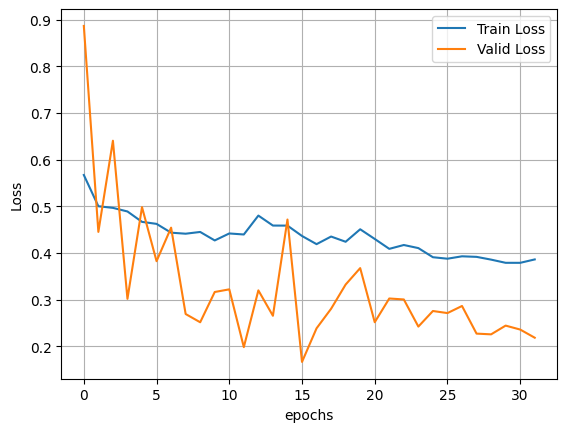

In [32]:
plt.plot( range(len(history["Train Loss"])), history["Train Loss"], label="Train Loss")
plt.plot( range(len(history["Valid Loss"])), history["Valid Loss"], label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

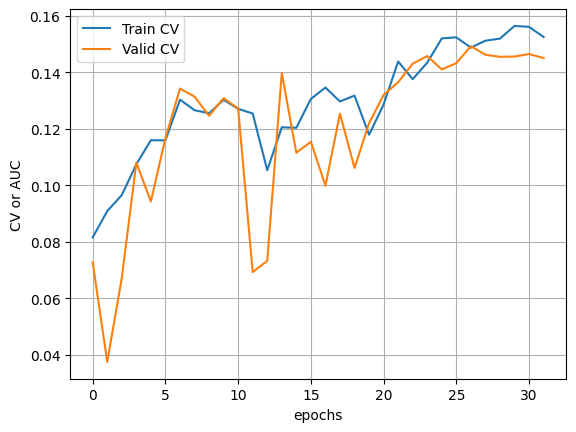

In [33]:
plt.plot( range(len(history["Train CV"])), history["Train CV"], label="Train CV")
plt.plot( range(len(history["Valid CV"])), history["Valid CV"], label="Valid CV")
plt.xlabel("epochs")
plt.ylabel("CV or AUC")
plt.grid()
plt.legend()
plt.show()

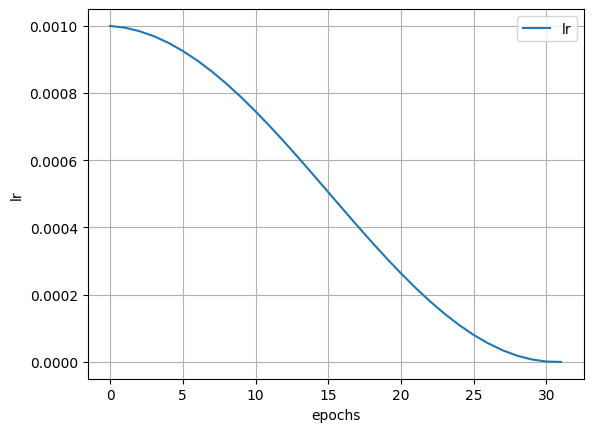

In [34]:
plt.plot( range(len(history["lr"])), history["lr"], label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()